# Six Degrees of Separation

A common computational task when dealing with random networks is studying how connected they are - which relates to the "six degrees of separation" concept, used to describe the interconnectedness of human social networks. The idea is that any two individuals can be connected to one another by a chain of six people that they know.

## Small World Network

To model this, we will create a network class to represent a "small world". The network object will construct $L$ nodes in the network, and will make two kinds of connections between the nodes:

* $Z$ short edges connecting to all other nodes of distance up to $Z/2$
* $pLZ/2$ shortcuts connecting two random nodes

There should be five methods implemented in the small world network class:

* `HasNode(node)` - check if a node is already in the network
* `AddNode(node)` - add a new node to the network
* `AddEdge(node1, node2)` - add a new edge to system
* `GetNodes()` - return list of existing nodes
* `GetNeighbors(node)` - return neighbors of an existing node

### Part A: SmallWorldNetwork Class

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import xkcd_palette as xkcd
from pprint import pprint
%matplotlib inline

In [2]:
# Define some colors
blue, green, red = xkcd(['denim blue', 'dusty green', 'brick red'])
purple, orange = xkcd(['dusty purple','burnt orange'])

In [3]:
class SmallWorldNetwork(object):
    """A SmallWorldNetwork represents a network of nodes
    connected with two types of edges:
    - short edges connecting nodes to their near-neighbors
    - long edges connecting random, distant nodes
    """
    def __init__(self, L, Z, p):
        """The constructor should first create all nodes,
        then create short edges, 
        then create random long edges.
        """
        self.G = nx.Graph()
        
        # Add nodes
        for i in range(L):
            self.addNode(i)
        
        # Add short edges
        for i in range(L):
            for j in range(L):
                if(i!=j):
                    if(abs(L+j-i)%L <= Z//2):
                        self.addEdge(i,j)
        
        # Add long edges
        for i in range(int(p*L*Z/2)):
            head = np.random.randint(0,L)
            tail = np.random.randint(0,L)
            if(head!=tail):
                self.addEdge(head,tail)
    
    def hasNode(self, node_id):
        """Check if graph has this node already
        """
        return node_id in list(G.nodes)
    
    def addNode(self, node_id):
        """Add new node to network
        """
        self.G.add_node(node_id)
    
    def addEdge(self, head_id, tail_id):
        """Add an edge between head and tail
        """
        self.G.add_edge(head_id, tail_id)
    
    def getNodes(self):
        """Get all nodes on the graph returned as a list
        """
        return list(self.G.nodes)
    
    def getNeighbors(self, node_id):
        """Get neighbors of a graph node
        """
        return self.G.neighbors(node_id)
        

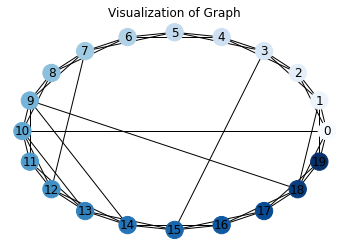

In [4]:
# Test that we can graph our SmallWorldNetwork
# (and make sure it looks ok)
s = SmallWorldNetwork(20,4,0.2)

fig, ax = plt.subplots(1,1)

nx.draw_circular(s.G, with_labels=True, node_color=range(20), cmap=plt.cm.Blues, ax=ax)
ax.set_title("Visualization of Graph")
plt.show()

### Part B: Shortest Path Measures

Now that we have a network class defined, we can define a method to measure the minimum distance between a pair of nodes (shortest path calculation). Without the random long edges, shortest paths must be achieved by hopping in steps of length $Z//2$ along the circle, and there are no paths longer than $L/Z$ (halfway around circle). 

As random long edges are added to the graph, the distribution of shortest paths will be shifted toward shorter path lengths.

Here, we define three methods:

* `findPathLengthsFromNode(graph, node)` - perform a breadth-first search, and compile the shortest path from a given node `node` to all other nodes in the graph.
* `findAllPathLengths(graph)` - using repeated calls to `findPathLengthsFromNode()`, this computes the shortest path of every 2-node pair on the graph.
* `findAveragePathLength(graph)` - using the results from `findAllPathLengths()`, compute the average shortest path length across all edge pairs on the graph.

In [5]:
def findPathLengthsFromNode(graph, node):
    """Use a breadth-first traversal to 
    work outward from node, in shells.
    """
    # BFS: queue (add every directly connected node to queue)
    # currentShell of nodes whose distance is set to l unless already visited
    # nextShell will be considered after current one is finished
    distances = {}
    currentShell = []
    nextShell = []
    
    # Initialize
    currentDist = 0
    currentShell.append(node)
    
    while(len(currentShell)>0):
        # Get the next node in currentShell
        node2 = currentShell.pop()
        
        distances[node2] = currentDist
        
        # For each child of each node in current shell,
        for child in graph.getNeighbors(node2):
            # if distance to child has not been set,
            if(child not in distances.keys()):
                # Add node to nextShell
                nextShell.append(child)
                # Set distance to currentDist+1
                distances[child] = currentDist + 1

        # if currentShell is empty, 
        # repopulate it with nextShell
        if(len(currentShell)==0):
            currentDist += 1
            while(len(nextShell)>0):
                currentShell.append(nextShell.pop())
    
    return distances

Now that we have defined a way to get the shortest path lengths from any node to all other nodes, we can create a histogram of the path lengths from a given node to all other nodes:

In [6]:
s = SmallWorldNetwork(100,4,0.2)

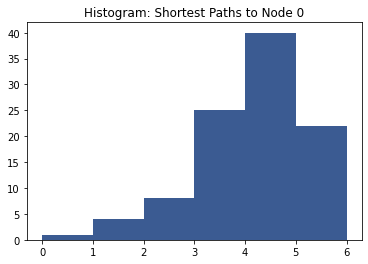

In [7]:
d0 = findPathLengthsFromNode(s,0)

nbins = max(list(d0.values()))
fig, ax = plt.subplots(1,1)
ax.hist(d0.values(), bins=nbins, color=blue)
ax.set_title("Histogram: Shortest Paths to Node 0")
plt.show()

Setting $p = 0$ reduceds the shortest path to a function of the graph size and value of $Z$ (interconnectedness of neighboring nodes). This results in a perfectly uniform distribution of shortest path lengths, because as the distance to node 0 gets larger, as you march around the circle of nodes, the shortest path is just the distance to node 0. This is like integrating over the angle $\theta$ as it sweeps around the circle and perfectly distributing the results.

In [8]:
def histogram_Z(z):
    sp0 = SmallWorldNetwork(100,z,0)
    dp0 = findPathLengthsFromNode(sp0,0)

    nbins = max(list(dp0.values()))
    fig, ax = plt.subplots(1,1)
    ax.hist(dp0.values(), bins=nbins, color=purple)
    ax.set_title("Histogram: Shortest Paths to Node 0 \nNo Random Connections")
    plt.show()
    

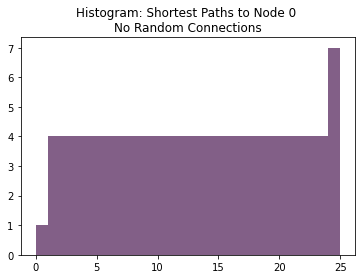

In [9]:
histogram_Z(4)

The next function we define is a method that finds the shortest path length between any two nodes; this treats the graph as undirected, i.e., it does not double-count the shortest path lengths (one path from node 1 to node 2 is not double-counted as a path from node 2 to node 1).

In [10]:
def findPathLengths(graph):
    all_distances = []
    all_nodes = graph.getNodes()
    
    # For each node, compute the shortest paths
    for i in range(len(all_nodes)):
        d = findPathLengthsFromNode(graph, i)
        # Save the shortest paths, but don't double-count
        for j in range(i,len(all_nodes)):
            # Save the tuple: (edge1, edge2, shortest_path)
            all_distances.append((i,j,d[j]))
    
    return all_distances

In [11]:
s = SmallWorldNetwork(100,4,0.2)
alldist = findPathLengths(s)

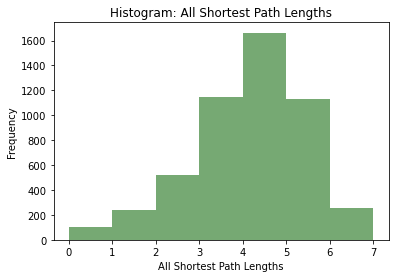

In [12]:
values = [k[2] for k in alldist]
nbins = max(values)
fig, ax = plt.subplots(1,1)

ax.hist(values, bins=nbins, color=green)
ax.set_title("Histogram: All Shortest Path Lengths")
ax.set_xlabel("All Shortest Path Lengths")
ax.set_ylabel("Frequency")

plt.show()

The third and final function computes the average shortest path length across all pairs of nodes on the graph. This just calls `findPathLengths()` and averages the results.

In [13]:
def findAveragePathLength(graph):
    d = findPathLengths(graph)
    return np.mean([k[2] for k in d])

In [14]:
s = SmallWorldNetwork(100,4,0.2)
findAveragePathLength(s)

3.7362376237623764

This average path length ends up having a somewhat wide distribution:

In [15]:
t = 10
pls = []
for i in range(t):
    s = SmallWorldNetwork(100,2,0.1)
    pl = findAveragePathLength(s)
    print("Trial %d:\t%6.02f"%(i+1, pl))
    pls.append(pl)
print("------------------------")
print("Mean:\t\t%6.02f"%(np.mean(np.array(pls))))
print("Std dev:\t%6.02f"%(np.std(np.array(pls))))

Trial 1:	  9.46
Trial 2:	 10.04
Trial 3:	  8.99
Trial 4:	 11.06
Trial 5:	  9.31
Trial 6:	 10.15
Trial 7:	  9.12
Trial 8:	  8.94
Trial 9:	  8.57
Trial 10:	  9.02
------------------------
Mean:		  9.47
Std dev:	  0.71


The histogram of average shortest path lengths shows that, for $L=100$, $Z=2$, and $p=0.1$, the average shortest path length between two nodes is around 10, but there is a considerable spread in the values. The histogram below is based on 100 trials.

In [16]:
ntrials = 100

avg_path_len = []
for i in range(ntrials):
    s = SmallWorldNetwork(100,2,0.1)
    pl = findAveragePathLength(s)
    avg_path_len.append(pl)

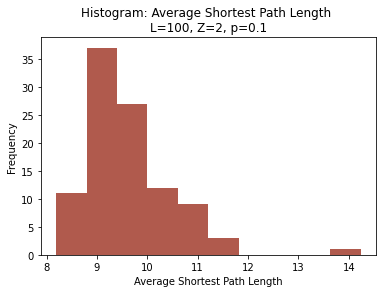

In [17]:
fig, ax = plt.subplots(1,1)

ax.hist(avg_path_len, bins=10, alpha=0.7, color=red)
ax.set_title("Histogram: Average Shortest Path Length \nL=100, Z=2, p=0.1")
ax.set_xlabel("Average Shortest Path Length")
ax.set_ylabel("Frequency")

plt.show()

We don't achieve Six Degrees of Kevin Bacon with $L=100, Z=2, p=0.1$ - needs more connectedness.

### Part C: Effect of Parameters

To examine the influence of the random edges on the connectivity of the graph, we can compute the average shortest path length for several graphs for each value of of a numerical parameter, and plot the results.

Below, we sample $p$ logarithmically and compute the mean shortest path length for several small world graphs for these different values of $p$.

In [18]:
ps = np.logspace(-3, 1, 15)

len_vs_p = []
for p in ps:
    pls = []
    for i in range(20):
        s = SmallWorldNetwork(50, 2, p)
        pl = findAveragePathLength(s)
        pls.append(pl)
    mean_pl = np.mean(pls)
    len_vs_p.append((p, mean_pl))

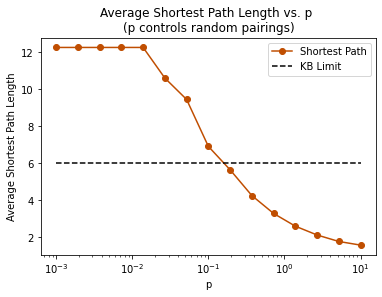

In [19]:
x = [k[0] for k in len_vs_p]
y = [k[1] for k in len_vs_p]

fig, ax = plt.subplots(1, 1)

ax.semilogx(x,y,'o-', label='Shortest Path', color=orange)

ax.plot((1e-3, 1e1), (6, 6), 'k--', label='KB Limit')

ax.set_title("Average Shortest Path Length vs. p \n(p controls random pairings)")
ax.set_xlabel("p")
ax.set_ylabel("Average Shortest Path Length")
ax.legend()

plt.show()

The plot shows that, at very low $p$ values, the average shortest path length is constant (and large). This is because, when $p$ is too small, there are *no* random long edges added to the graph, so the average shortest path length is fixed by the circle size and total number of nodes.

As the value of $p$ gets larger, long nodes become more likely. When $p$ reaches a value of 1, long edges are abundant between all nodes on the graph, and the average shortest path length approaches 1.

### Part D: Similarity to Watts and Strogatz

We examine the Watts and Strogatz system, which has parameter values of large L (here $L=500$), $Z=10$, and $p=0.1$ and $p=0.001$. 

We compare it to a *small* small world network for $L = 50$, $Z=2$, and $p=0.1$.

It is clear that the system with the much smaller $p$ value is more statistically similar to our own *small* small world network.

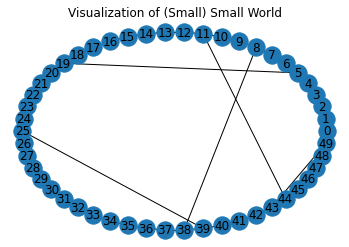

In [20]:
s = SmallWorldNetwork(50,2,0.1)

fig, ax = plt.subplots(1,1)

nx.draw_circular(s.G, with_labels=True, ax=ax)
ax.set_title("Visualization of (Small) Small World")
plt.show()

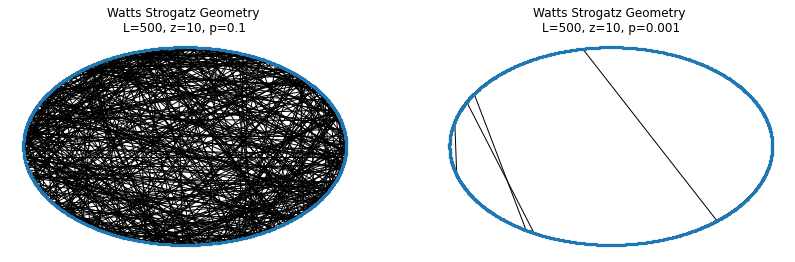

In [21]:
s1 = SmallWorldNetwork(1000,10,0.1)
s2 = SmallWorldNetwork(1000,10,0.001)

fig, ax = plt.subplots(1,2,figsize=(14,4))

nx.draw_circular(s1.G, node_size=5, ax=ax[0])
nx.draw_circular(s2.G, node_size=5, ax=ax[1])

ax[0].set_title("Watts Strogatz Geometry \nL=500, z=10, p=0.1")
ax[1].set_title("Watts Strogatz Geometry \nL=500, z=10, p=0.001")

plt.show()

The graph of mean path length vs. $p$ (above) showed that there was a continuum limit for the problem - in the limit of a large number of nodes $N$ and a fixed number of shortcuts $pLZ/2$, the distance around the circle is simply measured in radians $\Delta \theta$ around the circle.

To obtain a scaled mean length, divide the mean shortest path length $l(p)$ by the no-shortcut mean shortest path length $l(0)$. This is equivalent to normalizing by $L/2Z$, since $\Delta \theta = \dfrac{ \pi Z l(p) }{ L }$.

In [22]:
def scaled_mean_length(L, Z, p):
    s = SmallWorldNetwork(L, Z, p)
    p = findAveragePathLength(s)
    
    s0 = SmallWorldNetwork(L, Z, 0)
    p0 = findAveragePathLength(s0)
    
    return p/p0

In [23]:
import itertools

**Warning:** The following cell takes a minute to run.

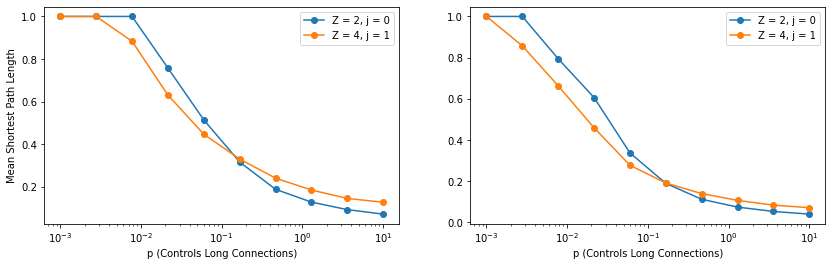

In [24]:
ntrials = 5

ps = np.logspace(-3, 1, 10)
Ls = [100, 200]
Zs = [2, 4]

fig, axes = plt.subplots(1,2,figsize=(14,4))

for i, L in enumerate(Ls):
    
    for j, Z in enumerate(Zs):
        
        original_geometry = []
        for p in ps:
            pls = []
            for k in range(ntrials):
                pl = scaled_mean_length(L, Z, p)
                pls.append(pl)
            mean_pl = np.mean(pls)
            original_geometry.append(mean_pl)
        
        if(j==0):
            style = "-o"
        else:
            style = "-o"
        
        axes[i].semilogx(ps, original_geometry, style, 
                        label = "Z = %d, j = %d"%(Z, j))
        axes[i].set_xlabel("p (Controls Long Connections)")
    axes[0].set_ylabel("Mean Shortest Path Length")
    
    axes[i].legend()

In [25]:
s = SmallWorldNetwork(50,2,0.08)
pos = nx.spectral_layout(s.G)
x = np.array(list(pos.values()))

Text(0.5, 1.0, 'Spectral Layout')

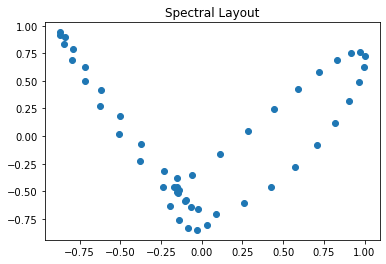

In [26]:
plt.plot(x[:,0],x[:,1],'o')
plt.title("Spectral Layout")

In [27]:
def spectral_plot(p):
    s = SmallWorldNetwork(50,2,p)
    pos = nx.spectral_layout(s.G)
    x = np.array(list(pos.values()))
    plt.plot(x[:,0],x[:,1],'o')
    plt.title("Spectral Layout, p = %0.2f"%(p))

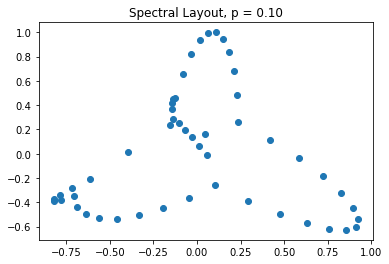

In [28]:
spectral_plot(0.1)

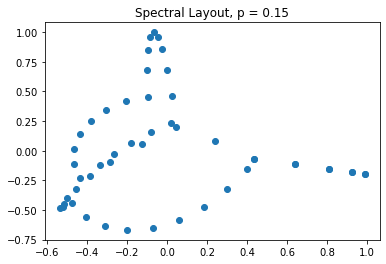

In [29]:
spectral_plot(0.15)

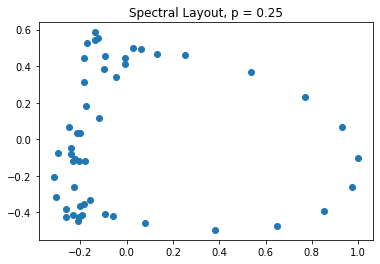

In [30]:
spectral_plot(0.25)

[mayavi example](https://networkx.github.io/documentation/stable/auto_examples/3d_drawing/mayavi2_spring.html?highlight=interactive)

In [31]:
#from mayavi import mlab